# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## Load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

train       = data['x_train'] 
train_noise = data['x_train_noise']

test        = data['x_test'] 
test_noise  = data['x_test_noise']

num_train   = train.shape[0]
num_test    = test.shape[0]

In [3]:
print('*************************************************')
print('size of train :', train.shape)
print('size of train_noise :', train_noise.shape)
print('*************************************************')
print('size of test :', test.shape)
print('size of test_noise :', test_noise.shape)
print('*************************************************')

*************************************************
size of train : (10000, 32, 32)
size of train_noise : (10000, 32, 32)
*************************************************
size of test : (5000, 32, 32)
size of test_noise : (5000, 32, 32)
*************************************************


## plot examples of the data

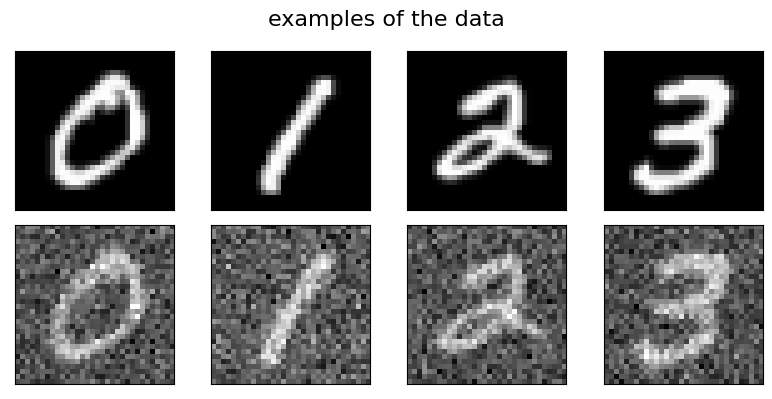

In [4]:
nRow = 2
nCol = 4
size = 2

title       = 'examples of the data'
fig, axes   = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
fig.suptitle(title, fontsize=16)

for c in range(nCol):

    axes[0, c].imshow(train[c * 1000], cmap='gray')
    axes[1, c].imshow(train_noise[c * 1000], cmap='gray')

    axes[0, c].xaxis.set_visible(False)
    axes[1, c].xaxis.set_visible(False)
    
    axes[0, c].yaxis.set_visible(False)
    axes[1, c].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## custom data loader for the PyTorch framework

In [5]:
class dataset(Dataset):
    
    def __init__(self, image, image_noise):
        
        self.image          = image
        self.image_noise    = image_noise
    
    def __getitem__(self, index):
        
        image       = self.image[index]
        image_noise = self.image_noise[index]

        image       = torch.FloatTensor(image).unsqueeze(dim=0)
        image_noise = torch.FloatTensor(image_noise).unsqueeze(dim=0)

        return (image, image_noise)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [7]:
print(device)

mps


In [8]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders for testing and testing

In [9]:
# ================================================== 
# determine your own parameter value
#
size_minibatch      = 32
#
# ================================================== 

dataset_train       = dataset(train, train_noise)
dataset_test        = dataset(test, test_noise)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)

## shape of the data when using the data loader

In [9]:
train_image, train_image_noise = next(iter(dataloader_train))
test_image, test_image_noise = next(iter(dataloader_test))

In [10]:
print('************************************************************')
print('size of mini-batch of the training image:', train_image.shape)
print('************************************************************')
print('size of mini-batch of the training image_noise:', train_image_noise.shape)
print('************************************************************')
print('size of mini-batch of the testing image:', test_image.shape)
print('************************************************************')
print('size of mini-batch of the testing image_noise:', test_image_noise.shape)
print('************************************************************')

************************************************************
size of mini-batch of the training image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the training image_noise: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the testing image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the testing image_noise: torch.Size([32, 1, 32, 32])
************************************************************


## construct a neural network 

In [10]:
# # ================================================== 
# # define your own neural network architecture and initialization
# #
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         # -------------------------------------------------
#         # Encoder
#         # -------------------------------------------------
#         self.encoder_layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
#             nn.MaxPool2d(2,2),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#         )
        
#         self.encoder_layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.MaxPool2d(2,2),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#         )

#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------
#         self.decoder_layer2 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#         )
        
#         self.decoder_layer1 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.Sigmoid(),
#         )

#         # -------------------------------------------------
#         # Network
#         # -------------------------------------------------
#         self.network = nn.Sequential(
#             self.encoder_layer1,
#             self.encoder_layer2,
#             self.decoder_layer2, 
#             self.decoder_layer1,
#         )
        
#         self.initialize_weight()

#     def forward(self,x):
    
#         out = self.network(x)
      
#         return out

#     # ======================================================================
#     # initialize weights
#     # ======================================================================
#     def initialize_weight(self):
            
#         for m in self.network.modules():
            
#             if isinstance(m, nn.Conv2d):

#                 nn.init.xavier_uniform_(m.weight) 
#                 if m.bias is not None:

#                     nn.init.constant_(m.bias, 1)
#                     pass
                    
#             elif isinstance(m, nn.BatchNorm2d):
                
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 1)
                
#             elif isinstance(m, nn.Linear):

#                 nn.init.xavier_uniform_(m.weight)

#                 if m.bias is not None:
                    
#                     nn.init.constant_(m.bias, 1)
#                     pass
# #
# # ================================================== 

# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()
    
#         self.encoder_layer1 = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#         )
#         self.encoder_layer2 = nn.Sequential(
#                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#         )
#         self.encoder_layer3 = nn.Sequential(
#                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#         )
            
#         self.decoder_layer3 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#         )
#         self.decoder_layer2 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#         )
#         self.decoder_layer1 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
#                         nn.Sigmoid(),
#         )

#         self.network = nn.Sequential(
#             self.encoder_layer1,
#             self.encoder_layer2,
#             self.encoder_layer3,
#             self.decoder_layer3,
#             self.decoder_layer2, 
#             self.decoder_layer1,
#         )
        
#         self.initialize_weight()

#     def forward(self,x):
#         out = self.network(x)
#         return out

#     def initialize_weight(self):
#         for m in self.network.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 1)
#                     pass
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 1)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 1)
#                     pass


# 3
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()
    
#         self.encoder_layer1 = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(32),
#         )
#         self.encoder_layer2 = nn.Sequential(
#                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#         )
#         self.encoder_layer3 = nn.Sequential(
#                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#         )
            
#         self.decoder_layer3 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#         )
#         self.decoder_layer2 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(32),
#         )
#         self.decoder_layer1 = nn.Sequential(
#                         nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
#                         nn.Sigmoid(),
#         )

#         self.network = nn.Sequential(
#             self.encoder_layer1,
#             self.encoder_layer2,
#             self.encoder_layer3,
#             self.decoder_layer3,
#             self.decoder_layer2, 
#             self.decoder_layer1,
#         )
        
#         self.initialize_weight()

#     def forward(self,x):
#         out = self.network(x)
#         return out

#     def initialize_weight(self):
#         for m in self.network.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 1)
#                     pass
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 1)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 1)
#                     pass

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )
        
        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [11]:
# ================================================== 
# determine your own parameter value
#
learning_rate   = 0.03
weight_decay    = 0.0001
alpha           = 0.003
number_epoch    = 200
#
# ================================================== 

model       = Network().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [12]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

## compute the data fidelity term
- use the mean squared error for the data fidelity term
- use the following loss function `nn.MSELoss()`
- input dimension: mini-batch-size x channel x height x width

In [13]:
def compute_loss_data_fidelity(prediction, original):
    # ================================================== 
    # fill up the blank
    #    
    loss = nn.MSELoss()(prediction, original)
    #
    # ================================================== 

    return loss

## compute the regularization term
- use the total variation for the regularization term
- use the following loss function: $\frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial x} f(x, y) \rvert + \frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial y} f(x, y) \rvert$
- use the neumann boundary condition (gradient of the boundary to the normal direction is zero)

In [14]:
def compute_loss_regularization(prediction):
    # ================================================== 
    # fill up the blank
    #    
    loss = (torch.sum(torch.abs(torch.sub(prediction[:,:,1:,:], prediction[:,:,:-1,:]))) \
            + torch.sum(torch.abs(torch.sub(prediction[:,:,:,1:], prediction[:,:,:,:-1])))) \
    / (prediction.size(0) * prediction.size(1) * prediction.size(2) * prediction.size(3))
    #
    # ================================================== 

    return loss

## compute the total loss
- total loss = data fidelity + $\alpha$ * regularization
- $\alpha \in \mathbb{R}$

In [15]:
def compute_loss(prediction, original, alpha):
    # ================================================== 
    # fill up the blank
    #    
    loss_data_fidelity  = compute_loss_data_fidelity(prediction, original)
    loss_regularization = compute_loss_regularization(prediction)

    loss = loss_data_fidelity + alpha * loss_regularization
    #
    # ================================================== 

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [16]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the PSNR metric

- input dimension: mini-batch-size x channel x height x width
- psnr is defined by $10 * \log_{10}(\frac{1}{\textrm{MSE}})$
- MSE is defined by $\textrm{MSE}(x, y) = \frac{1}{n} \| x - y \|_2^2$ where $n$ is the length of data $x$ and $y$

In [17]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [18]:
loss_train_mean = np.zeros(number_epoch)
loss_train_std  = np.zeros(number_epoch)
psnr_train_mean = np.zeros(number_epoch)
psnr_train_std  = np.zeros(number_epoch)

loss_test_mean  = np.zeros(number_epoch)
loss_test_std   = np.zeros(number_epoch)
psnr_test_mean  = np.zeros(number_epoch)
psnr_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [19]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.train()

    for index_batch, (image, image_noise) in enumerate(dataloader):

        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #               
        prediction                  = compute_prediction(model, image_noise)
        loss_all                    = compute_loss(prediction, image_noise, alpha)
        loss_value                  = compute_loss_value(loss_all[0])
        loss_data_fidelity_value    = compute_loss_value(loss_all[1])
        loss_regularization_value   = compute_loss_value(loss_all[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

        # ================================================== 
        # fill up the blank (update moodel parameters)
        #       
        optimizer.zero_grad()
        loss_all[0].backward()
        optimizer.step()
        #
        # ==================================================  

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## test

In [20]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.eval()

    for index_batch, (image, image_noise) in enumerate(dataloader):
    
        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #               
        prediction                  = compute_prediction(model, image_noise)
        loss_all                    = compute_loss(prediction, image_noise, alpha)
        loss_value                  = compute_loss_value(loss_all[0])
        loss_data_fidelity_value    = compute_loss_value(loss_all[1])
        loss_regularization_value   = compute_loss_value(loss_all[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## train and test

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, psnr_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    psnr_train_mean[i]  = psnr_train['mean']
    psnr_train_std[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, psnr_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    psnr_test_mean[i]  = psnr_test['mean']
    psnr_test_std[i]   = psnr_test['std']

  0%|                                                   | 0/200 [00:00<?, ?it/s]/opt/homebrew/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████████████████████████████████| 200/200 [27:10<00:00,  8.15s/it]


---

## functions for presenting the results

---

In [22]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [24]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [25]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [26]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [27]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [28]:
def function_result_07():
    
    title           = 'psnr (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_train_mean)), psnr_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_train_mean)), psnr_train_mean - psnr_train_std, psnr_train_mean + psnr_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [29]:
def function_result_08():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_test_mean)), psnr_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_test_mean)), psnr_test_mean - psnr_test_std, psnr_test_mean + psnr_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [30]:
def function_result_09():

    nRow = 9
    nCol = 3
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])

    image           = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_train.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3
    
    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [31]:
def function_result_10():
    
    nRow = 9 
    nCol = 3
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image     = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
    
    image           = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_test.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [32]:
def function_result_11():
    
    print('final training psnr = %9.8f' % (psnr_train_mean[-1]))

In [33]:
def function_result_12():
    
    print('final testing psnr = %9.8f' % (psnr_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



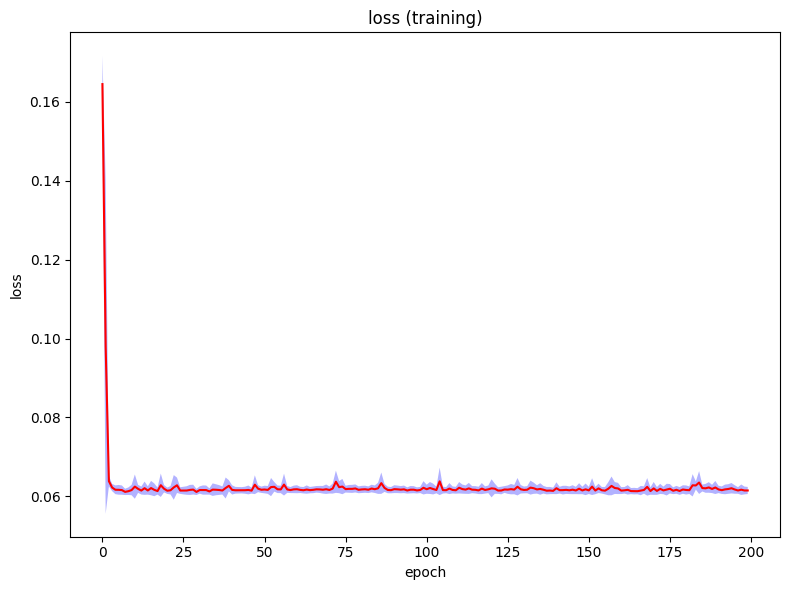


################################################################################
#
# RESULT # 02
#
################################################################################



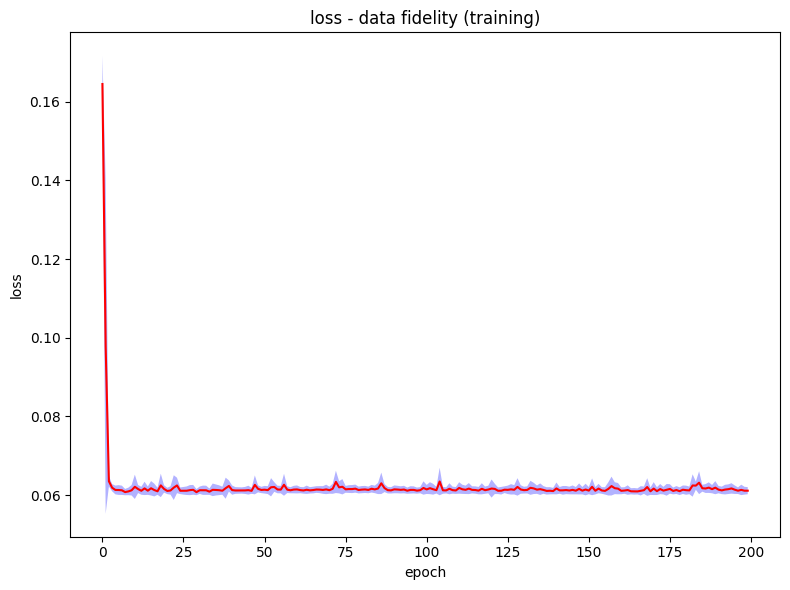


################################################################################
#
# RESULT # 03
#
################################################################################



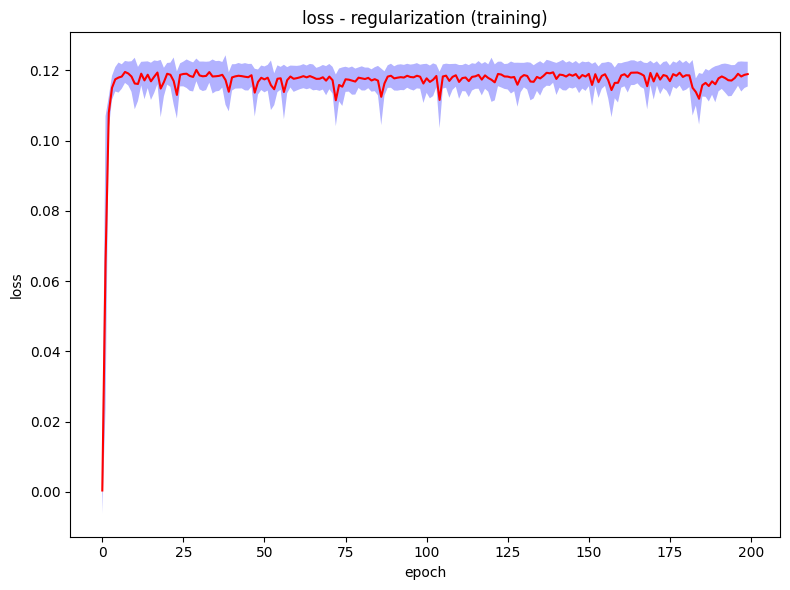


################################################################################
#
# RESULT # 04
#
################################################################################



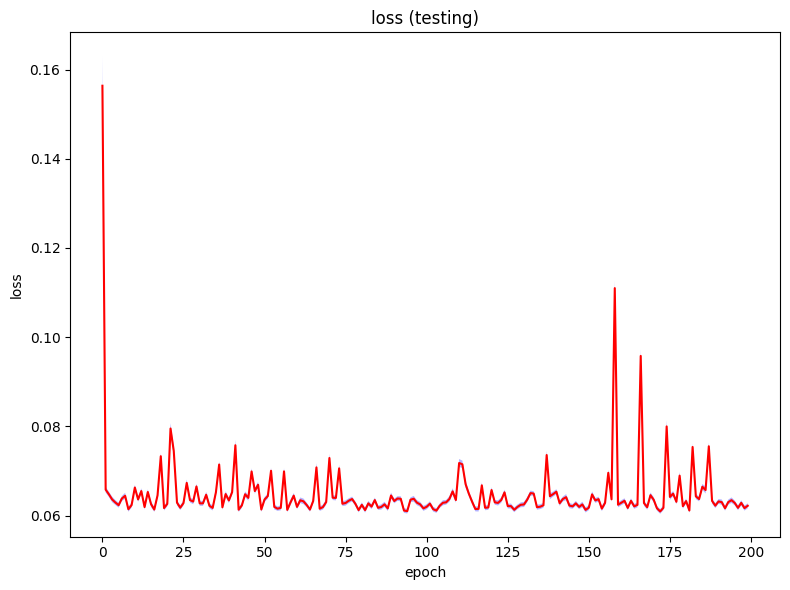


################################################################################
#
# RESULT # 05
#
################################################################################



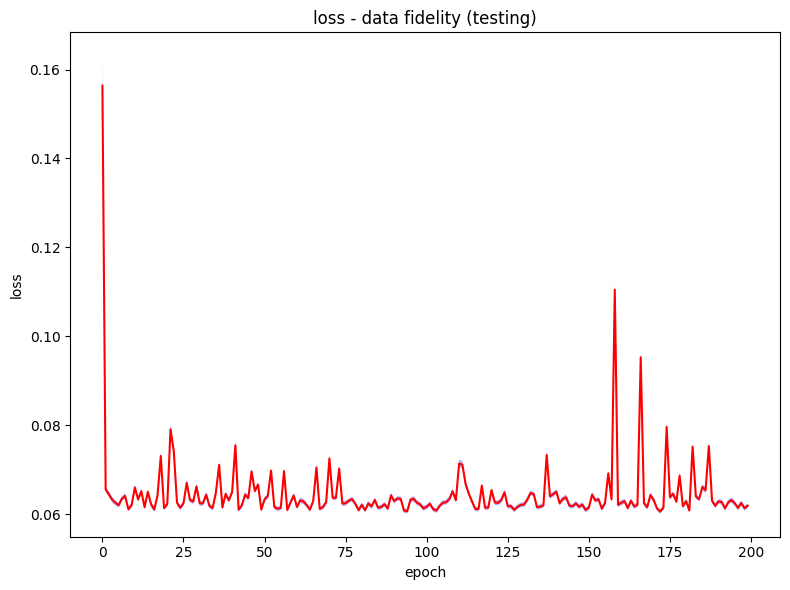


################################################################################
#
# RESULT # 06
#
################################################################################



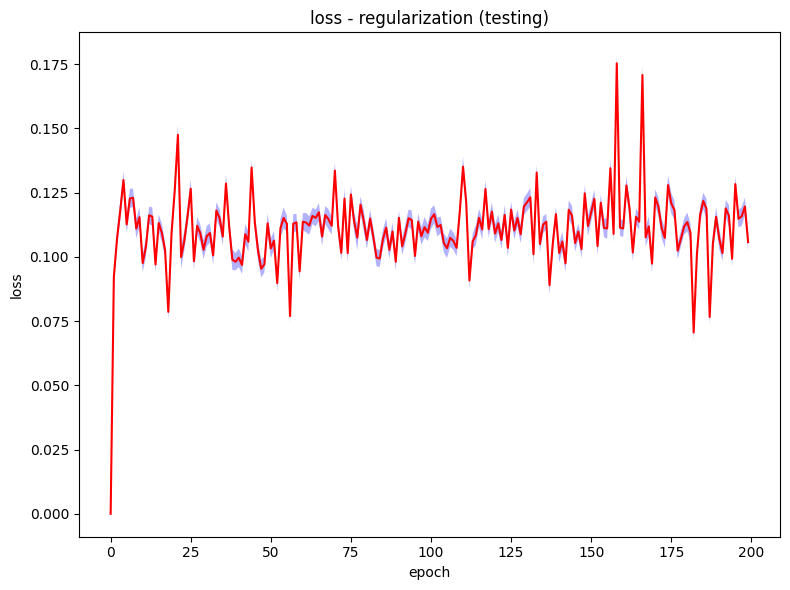


################################################################################
#
# RESULT # 07
#
################################################################################



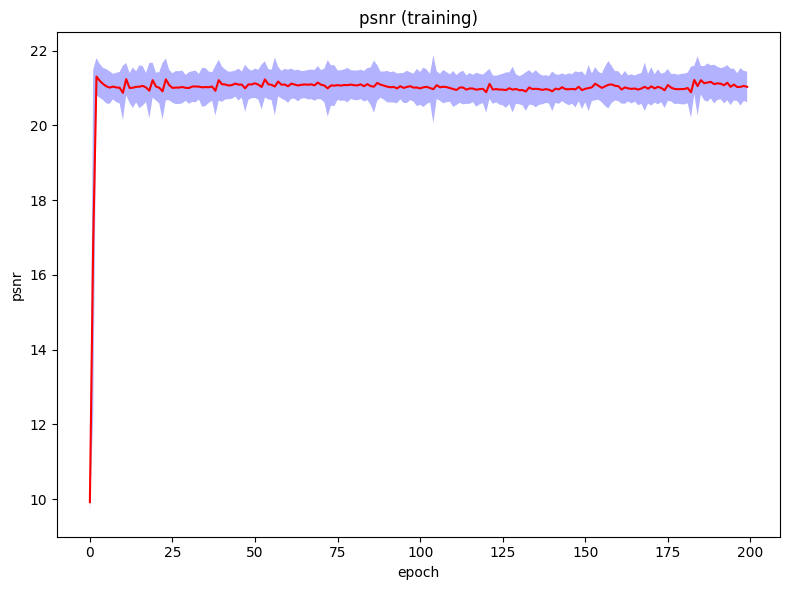


################################################################################
#
# RESULT # 08
#
################################################################################



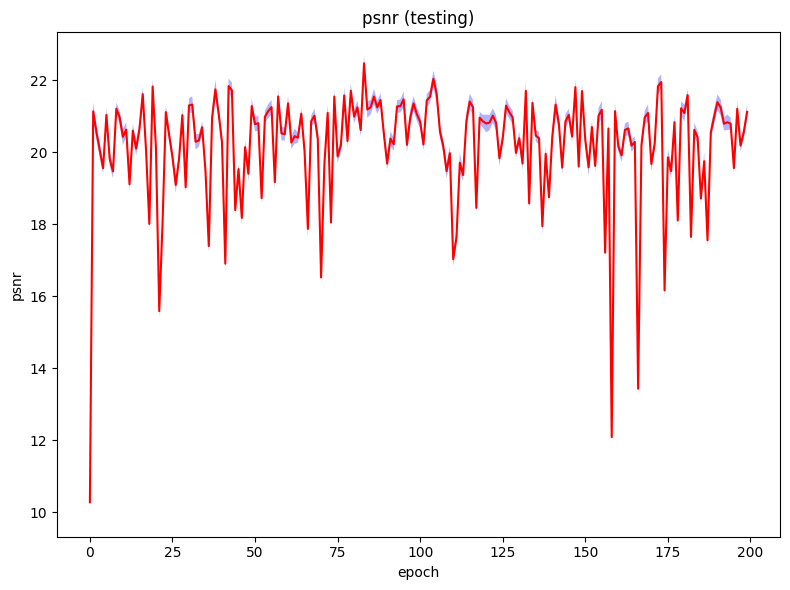


################################################################################
#
# RESULT # 09
#
################################################################################



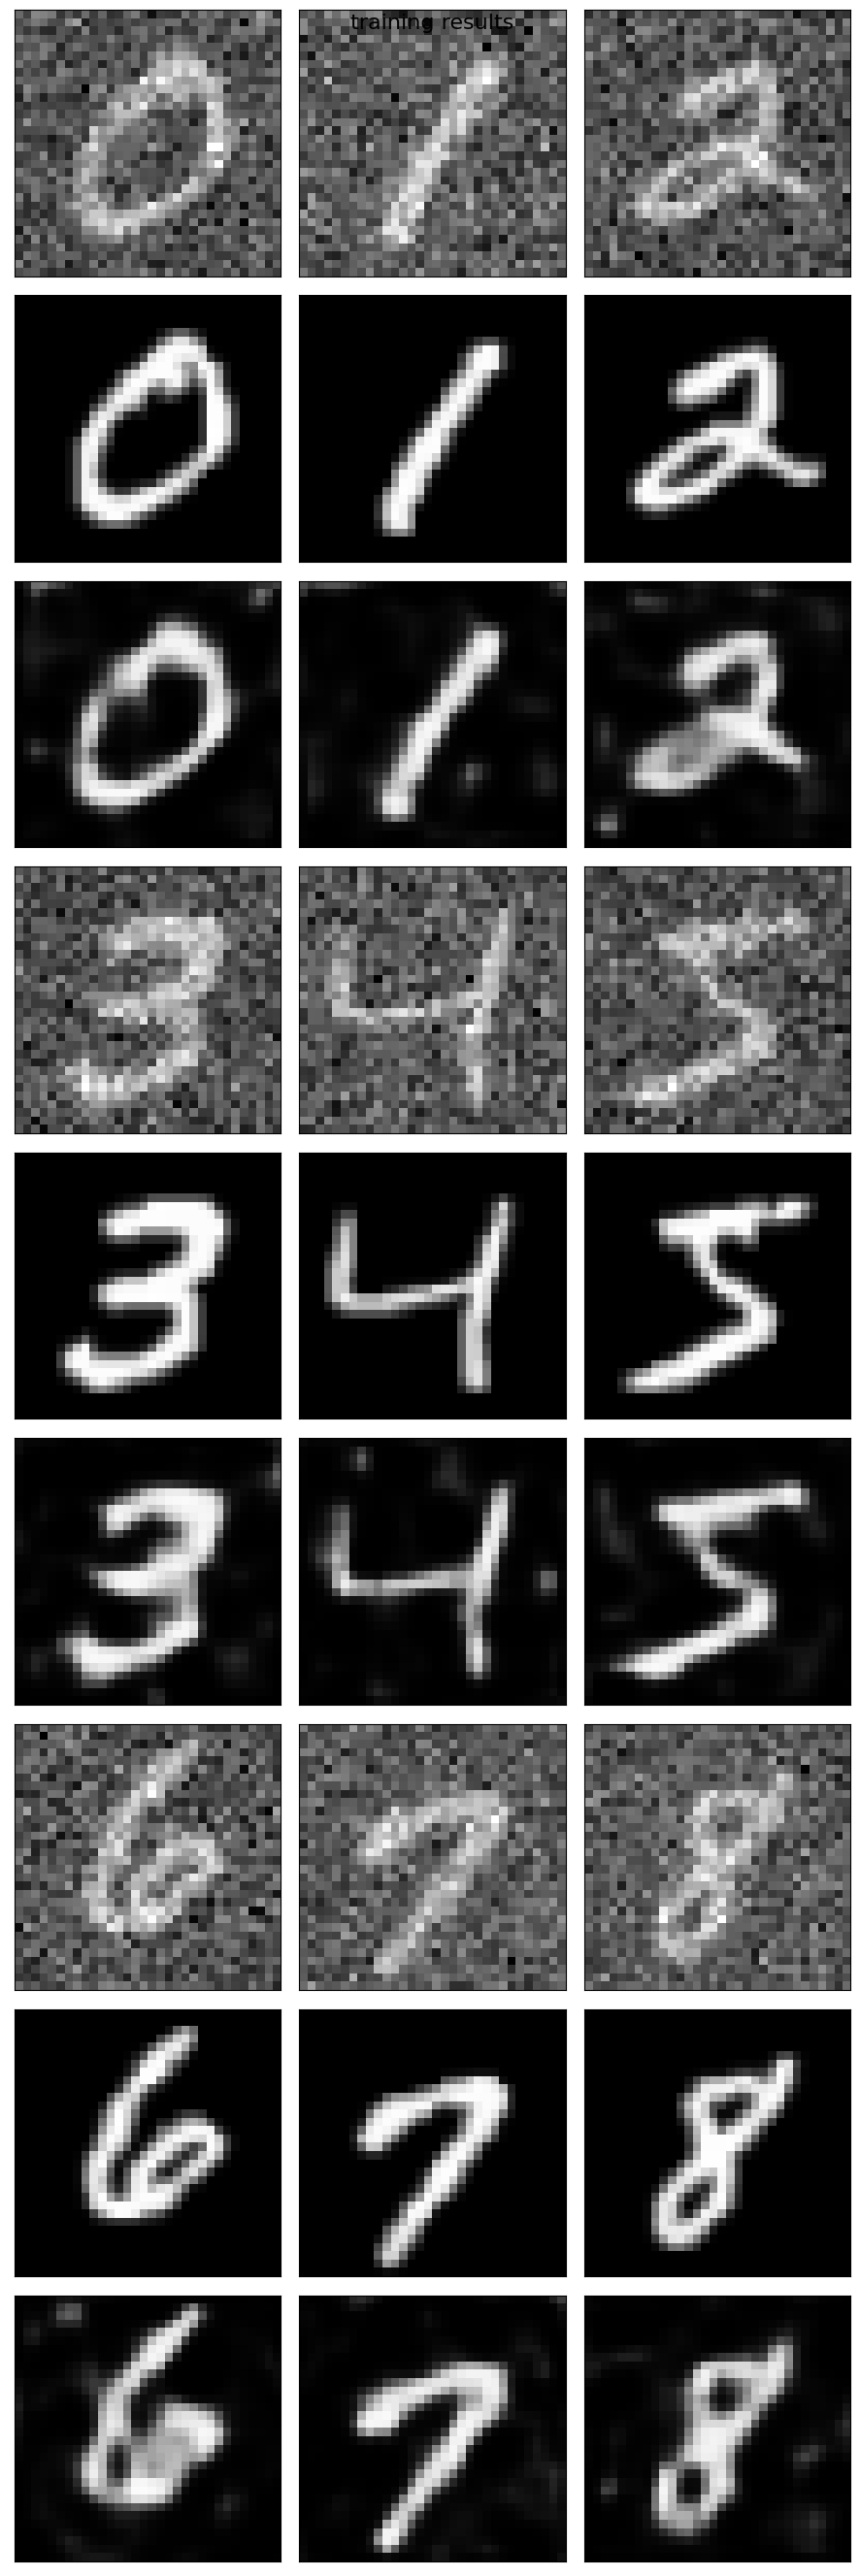


################################################################################
#
# RESULT # 10
#
################################################################################



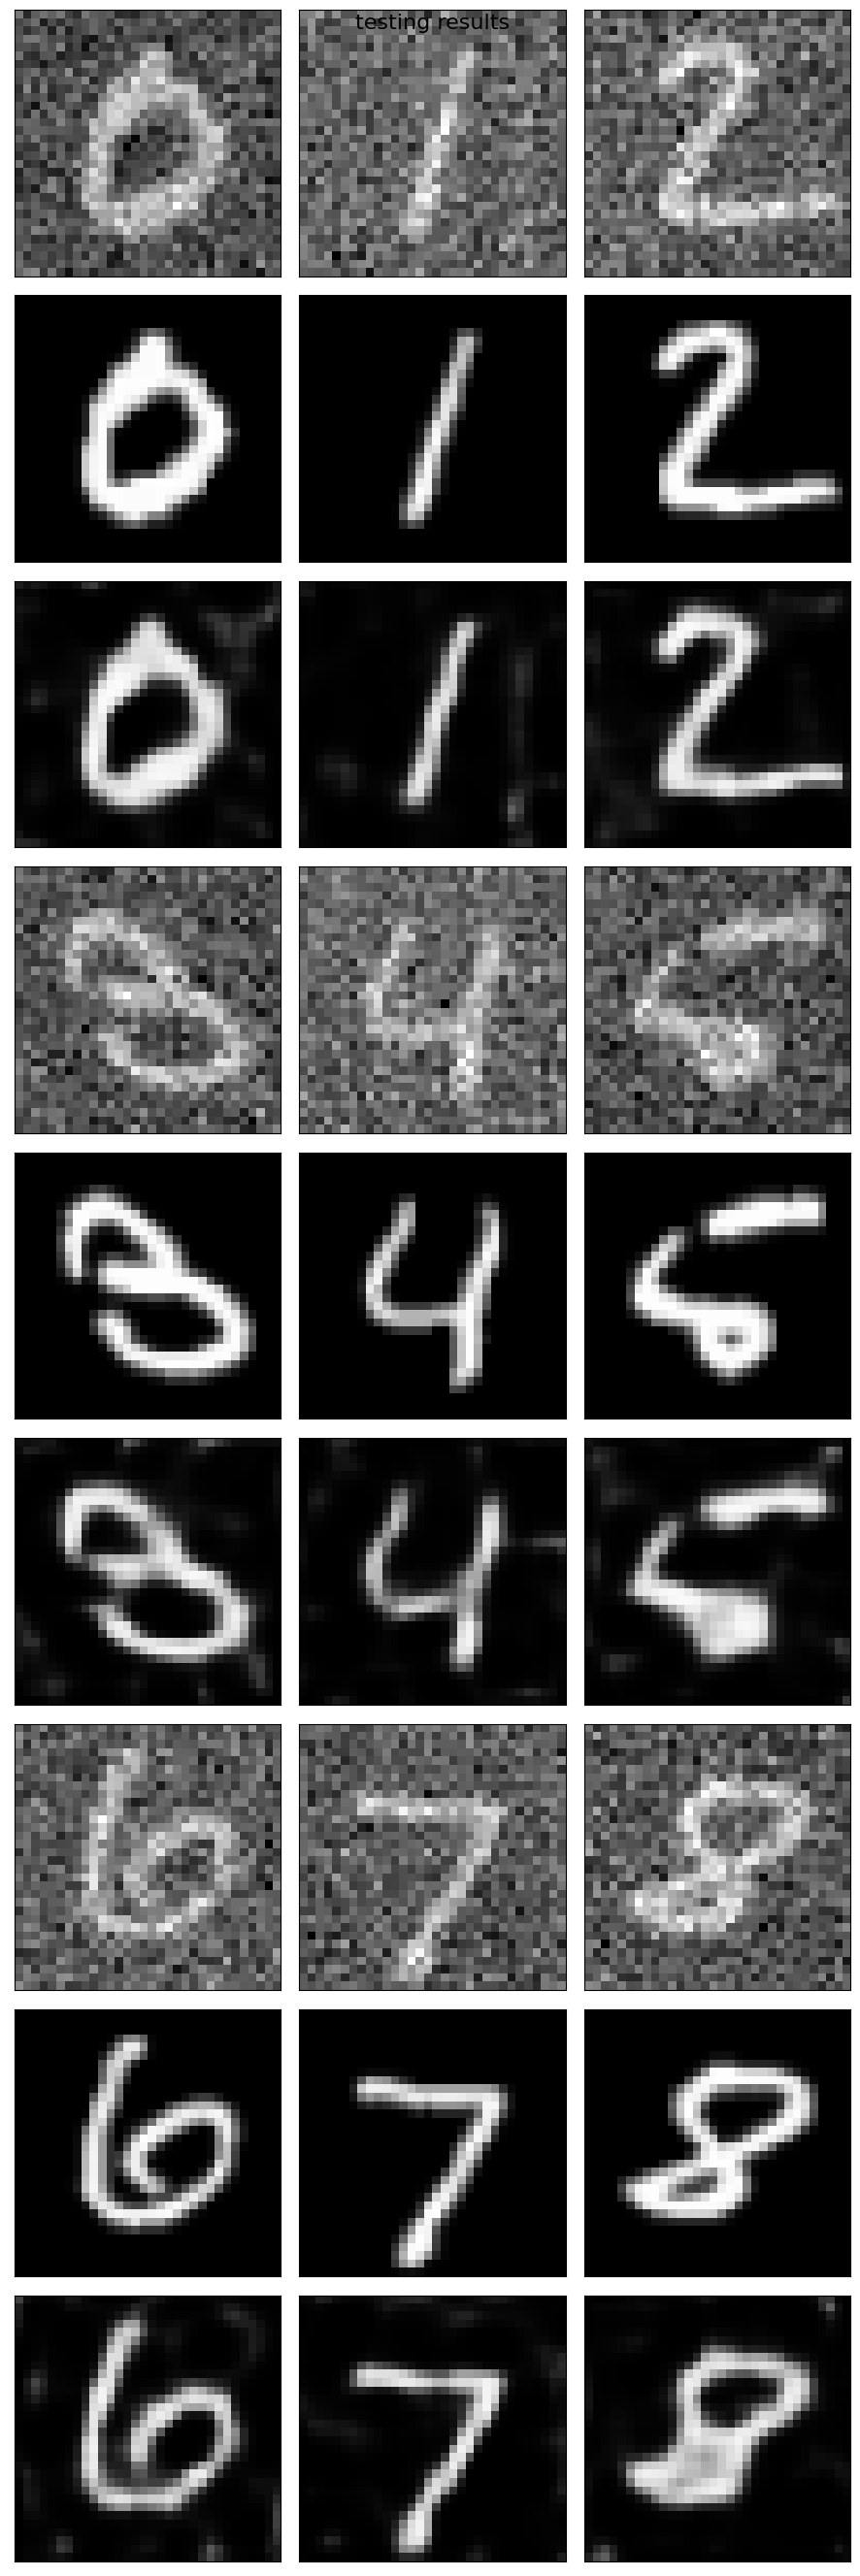


################################################################################
#
# RESULT # 11
#
################################################################################

final training psnr = 21.03305502

################################################################################
#
# RESULT # 12
#
################################################################################

final testing psnr = 21.12080956


In [34]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [13]:
import gc
import random

In [14]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

train_data       = data['x_train'] 
train_noise = data['x_train_noise']

test_data        = data['x_test'] 
test_noise  = data['x_test_noise']

num_train   = train_data.shape[0]
num_test    = test_data.shape[0]


# ================================================== 
# determine your own parameter value
#
size_minibatch      = 32
#
# ================================================== 

dataset_train       = dataset(train_data, train_noise)
dataset_test        = dataset(test_data, test_noise)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)



# ================================================== 
# define your own neural network architecture and initialization
#
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )
        
        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass
#
# ================================================== 
                
    
    
    # ================================================== 
# determine your own parameter value
#

lr = [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
al = [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
wd = [0.0001, 0.000001]

for lrx in lr:
    for alx in al:
        for wdx in wd:

            # random seed
            import random
            random.seed(20184757)
            np.random.seed(20184757)
            torch.manual_seed(20184757)
            torch.cuda.manual_seed(20184757)
            torch.cuda.manual_seed_all(20184757)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            learning_rate   = lrx
            weight_decay    = wdx
            alpha           = alx
            number_epoch    = 200
            #
            # ================================================== 

            model       = Network().to(device)
            optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            loss_train_mean = np.zeros(number_epoch)
            loss_train_std  = np.zeros(number_epoch)
            psnr_train_mean = np.zeros(number_epoch)
            psnr_train_std  = np.zeros(number_epoch)

            loss_test_mean  = np.zeros(number_epoch)
            loss_test_std   = np.zeros(number_epoch)
            psnr_test_mean  = np.zeros(number_epoch)
            psnr_test_std   = np.zeros(number_epoch)

            loss_train_data_fidelity_mean   = np.zeros(number_epoch)
            loss_train_data_fidelity_std    = np.zeros(number_epoch)
            loss_train_regularization_mean  = np.zeros(number_epoch)
            loss_train_regularization_std   = np.zeros(number_epoch)

            loss_test_data_fidelity_mean    = np.zeros(number_epoch)
            loss_test_data_fidelity_std     = np.zeros(number_epoch)
            loss_test_regularization_mean   = np.zeros(number_epoch)
            loss_test_regularization_std    = np.zeros(number_epoch)
            
            
            # ================================================================================
            # 
            # iterations for epochs
            #
            # ================================================================================
            for i in tqdm(range(number_epoch)):

                # ================================================================================
                # 
                # training
                #
                # ================================================================================
                (loss_train, loss_data_fidelity_train, loss_regularization_train, psnr_train) = train(model, optimizer, dataloader_train)

                loss_train_mean[i]  = loss_train['mean']
                loss_train_std[i]   = loss_train['std']

                loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
                loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

                loss_train_regularization_mean[i]   = loss_regularization_train['mean']
                loss_train_regularization_std[i]    = loss_regularization_train['std']

                psnr_train_mean[i]  = psnr_train['mean']
                psnr_train_std[i]   = psnr_train['std']

                # ================================================================================
                # 
                # testing
                #
                # ================================================================================
                (loss_test, loss_data_fidelity_test, loss_regularization_test, psnr_test) = test(model, dataloader_test)

                loss_test_mean[i]  = loss_test['mean']
                loss_test_std[i]   = loss_test['std']

                loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
                loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

                loss_test_regularization_mean[i]   = loss_regularization_test['mean']
                loss_test_regularization_std[i]    = loss_regularization_test['std']

                psnr_test_mean[i]  = psnr_test['mean']
                psnr_test_std[i]   = psnr_test['std']
                
                
            print(np.max(psnr_test_mean), np.argmax(psnr_test_mean), lrx, alx, wdx)
            gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:11<00:00,  3.06s/it]


21.30355639919405 164 0.1 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:03<00:00,  3.02s/it]


22.86826481844075 39 0.1 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:03<00:00,  3.02s/it]


21.21078692836164 180 0.1 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


22.760253083573055 39 0.1 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


21.195971892471096 88 0.1 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


22.25485412817595 153 0.1 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:53<00:00,  2.97s/it]


21.18505141519862 152 0.1 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


19.268672932087075 42 0.1 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


21.195931946836428 116 0.1 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


22.955089757312845 163 0.1 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:54<00:00,  2.97s/it]


21.147855506450114 161 0.1 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:02<00:00,  3.01s/it]


22.382123925824363 54 0.1 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:02<00:00,  3.01s/it]


20.99219507867522 194 0.1 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:55<00:00,  2.98s/it]


22.563049827264305 52 0.1 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


22.723821267265432 91 0.03 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:40<00:00,  3.20s/it]


22.639512033661873 17 0.03 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:16<00:00,  3.08s/it]


22.337699658676325 128 0.03 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:59<00:00,  3.00s/it]


21.951415211851554 19 0.03 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:06<00:00,  3.03s/it]


22.25088932797704 168 0.03 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:49<00:00,  3.25s/it]


22.19842106916427 12 0.03 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


22.2018924331459 196 0.03 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


21.69696601275316 12 0.03 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:54<00:00,  2.97s/it]


21.886437312721217 149 0.03 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


22.315559654235795 13 0.03 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


22.185888265006316 128 0.03 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


21.034326413722074 15 0.03 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.121262668678426 94 0.03 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.07151227050924 12 0.03 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:03<00:00,  3.02s/it]


22.91741222732529 128 0.01 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


22.40779828271442 1 0.01 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


21.87579136827915 0 0.01 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


22.517029001400545 0 0.01 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


22.09577778440305 1 0.01 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


21.263108531083926 3 0.01 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:55<00:00,  2.98s/it]


21.247439999939644 2 0.01 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


21.588103207592518 1 0.01 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


21.755361054420703 1 0.01 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  3.05s/it]


21.26640202105952 1 0.01 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:26<00:00,  3.13s/it]


21.539998490523875 2 0.01 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:16<00:00,  3.08s/it]


21.261428861014572 1 0.01 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


21.26986990406845 0 0.01 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:28<00:00,  3.14s/it]


21.96699277241722 0 0.01 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:25<00:00,  3.13s/it]


22.953548138802944 1 0.003 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:36<00:00,  3.18s/it]


22.732920752505436 4 0.003 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:36<00:00,  3.18s/it]


22.532029030578034 0 0.003 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:37<00:00,  3.19s/it]


21.98849218899494 0 0.003 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:24<00:00,  3.12s/it]


22.06367790752561 0 0.003 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:04<00:00,  3.02s/it]


21.445173058318467 1 0.003 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:05<00:00,  3.03s/it]


21.8063628604914 1 0.003 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  3.05s/it]


21.218037159206077 1 0.003 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:59<00:00,  3.00s/it]


21.622989558263153 1 0.003 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


21.522678862356333 0 0.003 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


22.100186905999262 0 0.003 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]


21.366864290236716 0 0.003 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


21.77697197671958 1 0.003 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  3.05s/it]


21.318908298694634 1 0.003 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:11<00:00,  3.06s/it]


22.867185846001103 4 0.001 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


23.04260688158026 4 0.001 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.330050877853747 2 0.001 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:05<00:00,  3.03s/it]


22.402531939090682 1 0.001 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


21.994380384132054 3 0.001 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  2.96s/it]


22.058053520055157 2 0.001 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


21.940585649285374 2 0.001 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


21.970226357759888 2 0.001 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:55<00:00,  2.98s/it]


21.888685358362647 3 0.001 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


21.939174473005977 1 0.001 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


21.91465885823964 2 0.001 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:15<00:00,  3.08s/it]


21.919190673440955 1 0.001 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:19<00:00,  3.10s/it]


21.90340153585832 1 0.001 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  2.96s/it]


21.892781795361305 2 0.001 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:59<00:00,  3.00s/it]


23.080626445972573 7 0.0003 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


23.156131564399036 9 0.0003 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  2.96s/it]


22.46603768642444 4 0.0003 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


22.347956534906004 4 0.0003 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  3.05s/it]


22.18633864662855 4 0.0003 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.078241707987473 3 0.0003 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.078901536925194 4 0.0003 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:51<00:00,  2.96s/it]


21.982261478148676 3 0.0003 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


22.04211237188519 4 0.0003 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


21.933727626538996 1 0.0003 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


22.06428439886412 4 0.0003 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.024128756933425 3 0.0003 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.054294005264754 4 0.0003 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


21.99393770322575 3 0.0003 0.0001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


23.127887264385 15 0.0001 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]


23.14672745539518 15 0.0001 0.1 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.492113504292227 10 0.0001 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


22.478270436482788 10 0.0001 0.03 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:43<00:00,  2.92s/it]


22.18933905202905 10 0.0001 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:38<00:00,  2.89s/it]


22.18057489888356 7 0.0001 0.01 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.09389700975178 7 0.0001 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


22.09662308569933 7 0.0001 0.003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  3.05s/it]


22.07349196549055 7 0.0001 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:00<00:00,  3.00s/it]


22.070360782220533 7 0.0001 0.001 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:48<00:00,  2.94s/it]


22.07170300332134 7 0.0001 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:58<00:00,  2.99s/it]


22.058196877631662 7 0.0001 0.0003 1e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:41<00:00,  2.91s/it]


22.06640160521105 7 0.0001 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:12<00:00,  3.06s/it]

22.05337123404936 7 0.0001 0.0001 1e-06
